# Self-Distilling Transformers: A Use Case

This notebook provides a practical example of the Self-Distilling Transformers project. We will walk through the process of setting up the configuration, creating a dataset, initializing the model and trainer, and then running a short training and evaluation loop. We will also demonstrate the model pruning functionality.

## 1. Setup

First, let's import the necessary modules and define our configurations. We'll use smaller values for the model and training parameters to speed up this demonstration.

In [8]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from datasets import load_dataset
from transformers import PreTrainedTokenizerFast
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
from nltk.translate.bleu_score import sentence_bleu
import nltk

from config import ModelConfig, DistillConfig, TrainConfig
from data import HFTextDataset  # Dataset class for WikiText and other HF datasets
from model import GPTLike
from distillation import SelfDistillTrainer
from scheduler import CosineWithWarmup
from utils import set_seed, evaluate, prune_transformer

# Download necessary NLTK data
nltk.download('punkt')

# For reproducibility
set_seed(1337)

# More sophisticated model configuration
model_cfg = ModelConfig(
    d_model=256,      # Increased from 128
    n_head=8,         # Increased from 4
    d_ff=1024,        # Increased from 512
    n_layer=6,        # Increased from 4
    max_seq_len=128,
    dropout=0.1,
    vocab_size=None,  # Will be set after tokenization
)

# Enhanced distillation configuration
distill_cfg = DistillConfig(
    temperature=2.0,
    lambda_kd=0.7,
    lambda_sd=0.3,
    projector_dim=128,
    ema_decay=0.995,
    freeze_milestones=None,  # Simpler schedule
    freeze_fracs=None
)

# More extensive training configuration
train_cfg = TrainConfig(
    batch_size=4,
    lr=1e-4,                # Reduced learning rate
    warmup_steps=200,       # Adjusted warmup
    train_steps=4000,       # More training steps
    eval_every=500,         # Evaluate less frequently
    log_every=100,          # Log less frequently
    accum_steps=4,
    amp=True,
    layerdrop_p=0.1
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\khali\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version used by PyTorch: {torch.version.cuda}")
    print(f"GPU count: {torch.cuda.device_count()}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available to PyTorch.")

PyTorch version: 2.5.1+cpu
CUDA available: False
CUDA is not available to PyTorch.


## 2. Data

We'll use the WikiText-2 dataset, which is a collection of good and featured articles from Wikipedia. This provides a more realistic training scenario compared to synthetic data. The dataset will help us evaluate the model's ability to learn proper language structure and generate coherent text.

In [10]:
# Initialize tokenizer (using GPT-2 tokenizer as base)
tokenizer = PreTrainedTokenizerFast.from_pretrained("gpt2")

# Create train and validation datasets
train_ds = HFTextDataset('wikitext2', 'train', tokenizer, seq_len=model_cfg.max_seq_len)
val_ds = HFTextDataset('wikitext2', 'validation', tokenizer, seq_len=model_cfg.max_seq_len)

# Update vocab size in model config
model_cfg.vocab_size = tokenizer.vocab_size

# Create data loaders
train_loader = DataLoader(
    train_ds, 
    batch_size=train_cfg.batch_size, 
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_ds, 
    batch_size=train_cfg.batch_size,
    num_workers=2,
    pin_memory=True
)

print(f"Vocabulary size: {model_cfg.vocab_size:,}")
print(f"Training examples: {len(train_ds):,}")
print(f"Validation examples: {len(val_ds):,}")

# Show a sample from the dataset
sample_text = tokenizer.decode(next(iter(train_loader))['input_ids'][0].tolist())
print("\nSample text from dataset:")
print(sample_text[:200] + "...")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


Vocabulary size: 50,257
Training examples: 18,686
Validation examples: 1,931

Sample text from dataset:
 Janet Maslin wrote of Freewheelin ' : " These were the songs that established [ Dylan ] as the voice of his generation — someone who implicitly understood how concerned young Americans felt about nuc...

Sample text from dataset:
 Janet Maslin wrote of Freewheelin ' : " These were the songs that established [ Dylan ] as the voice of his generation — someone who implicitly understood how concerned young Americans felt about nuc...


## 3. Model and Trainer

Now, we'll instantiate the `GPTLike` model and the `SelfDistillTrainer`. The trainer manages the student and teacher models, the EMA updates, and the loss calculations.

In [11]:
# Create the student model
student = GPTLike(model_cfg, layerdrop_p=train_cfg.layerdrop_p).to(device)

# Create the trainer
trainer = SelfDistillTrainer(student, distill_cfg, device)

# Optimizer and scheduler
params = [p for p in list(student.parameters()) + list(trainer.predictors.parameters()) if p.requires_grad]
optim = torch.optim.AdamW(params, lr=train_cfg.lr, betas=train_cfg.betas, weight_decay=train_cfg.weight_decay)
sched = CosineWithWarmup(optim, warmup_steps=train_cfg.warmup_steps, total_steps=train_cfg.train_steps)

print(f"Student model parameters: {sum(p.numel() for p in student.parameters() if p.requires_grad):,}")
print(f"Predictors parameters: {sum(p.numel() for p in trainer.predictors.parameters()):,}")

Student model parameters: 30,470,656
Predictors parameters: 395,520


## 4. Training

We'll run a short training loop. In a real scenario, this would run for many more steps.

In [12]:
@torch.no_grad()
def evaluate_baseline(model, val_loader, device):
    model.eval()
    losses = []
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits, _ = model(batch['input_ids'])
        loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), batch['labels'].view(-1))
        losses.append(loss.item())
    model.train()
    val_loss = np.mean(losses)
    return {'val_loss': val_loss, 'val_ppl': np.exp(val_loss)}

# Baseline Model Training
print("--- Training Baseline Model (No Distillation) ---")
baseline_model = GPTLike(model_cfg).to(device)
baseline_optim = torch.optim.AdamW(baseline_model.parameters(), lr=train_cfg.lr, betas=(0.9, 0.98), weight_decay=0.1)
baseline_sched = CosineWithWarmup(baseline_optim, warmup_steps=train_cfg.warmup_steps, total_steps=train_cfg.train_steps)

baseline_history = {'train_loss': [], 'val_ppl': []}
global_step = 0
baseline_model.train()

pbar = tqdm(total=train_cfg.train_steps, desc="Training Baseline")
while global_step < train_cfg.train_steps:
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        baseline_optim.zero_grad()
        
        logits, _ = baseline_model(batch['input_ids'])
        loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), batch['labels'].view(-1))
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(baseline_model.parameters(), 1.0)
        baseline_optim.step()
        baseline_sched.step()
        
        baseline_history['train_loss'].append(loss.item())
        
        if global_step % train_cfg.log_every == 0:
            pbar.set_postfix({'loss': loss.item()})
            
        if global_step % train_cfg.eval_every == 0 and global_step > 0:
            eval_stats = evaluate_baseline(baseline_model, val_loader, device)
            baseline_history['val_ppl'].append(eval_stats['val_ppl'])
            print(f"\nEvaluation at step {global_step}: {eval_stats}")
            baseline_model.train()
        
        global_step += 1
        pbar.update(1)
        if global_step >= train_cfg.train_steps:
            break
pbar.close()
print("Baseline training finished.")

--- Training Baseline Model (No Distillation) ---


Training Baseline:   0%|          | 0/4000 [00:00<?, ?it/s]


Evaluation at step 500: {'val_loss': 7.117149969065411, 'val_ppl': 1232.931528357289}

Evaluation at step 1000: {'val_loss': 6.904604688687848, 'val_ppl': 996.8543676071735}

Evaluation at step 1000: {'val_loss': 6.904604688687848, 'val_ppl': 996.8543676071735}

Evaluation at step 1500: {'val_loss': 6.786885923974015, 'val_ppl': 886.149723054124}

Evaluation at step 1500: {'val_loss': 6.786885923974015, 'val_ppl': 886.149723054124}

Evaluation at step 2000: {'val_loss': 6.719969679356608, 'val_ppl': 828.7923815822465}

Evaluation at step 2000: {'val_loss': 6.719969679356608, 'val_ppl': 828.7923815822465}

Evaluation at step 2500: {'val_loss': 6.671724495186815, 'val_ppl': 789.7563618603982}

Evaluation at step 2500: {'val_loss': 6.671724495186815, 'val_ppl': 789.7563618603982}

Evaluation at step 3000: {'val_loss': 6.6398433878801875, 'val_ppl': 764.975179253712}

Evaluation at step 3000: {'val_loss': 6.6398433878801875, 'val_ppl': 764.975179253712}

Evaluation at step 3500: {'val_los

In [19]:
# Self-Distillation Training
print("\n--- Training Self-Distilled Model ---")
global_step = 0
student.train()
trainer.teacher.train()
distill_history = {'train_loss': [], 'val_ppl': []}

pbar = tqdm(total=train_cfg.train_steps, desc="Training Distilled")
while global_step < train_cfg.train_steps:
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optim.zero_grad()
        
        loss, stats = trainer.compute_losses(batch, train_mode=True)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 1.0)
        optim.step()
        sched.step()
        trainer.update_teacher()
        
        distill_history['train_loss'].append(stats['loss_total'])

        if global_step % train_cfg.log_every == 0:
            pbar.set_postfix(stats)
            
        if global_step % train_cfg.eval_every == 0 and global_step > 0:
            eval_stats = evaluate(trainer, val_loader, device)
            distill_history['val_ppl'].append(eval_stats['val_ppl'])
            print(f"\nEvaluation at step {global_step}: {eval_stats}")
            student.train()
        
        global_step += 1
        pbar.update(1)
        if global_step >= train_cfg.train_steps:
            break
pbar.close()
print("Distillation training finished.")


--- Training Self-Distilled Model ---


Training Distilled:   0%|          | 0/4000 [00:00<?, ?it/s]


Evaluation at step 500: {'val_loss': 10.193136880610053, 'val_ppl': 26719.178451707226}

Evaluation at step 1000: {'val_loss': 9.927507323507937, 'val_ppl': 20486.211386116305}

Evaluation at step 1000: {'val_loss': 9.927507323507937, 'val_ppl': 20486.211386116305}

Evaluation at step 1500: {'val_loss': 9.864648256242646, 'val_ppl': 19238.10556939343}

Evaluation at step 1500: {'val_loss': 9.864648256242646, 'val_ppl': 19238.10556939343}

Evaluation at step 2000: {'val_loss': 9.807485537005753, 'val_ppl': 18169.243700674655}

Evaluation at step 2000: {'val_loss': 9.807485537005753, 'val_ppl': 18169.243700674655}

Evaluation at step 2500: {'val_loss': 9.771188512845562, 'val_ppl': 17521.579470375003}

Evaluation at step 2500: {'val_loss': 9.771188512845562, 'val_ppl': 17521.579470375003}

Evaluation at step 3000: {'val_loss': 9.755913637686467, 'val_ppl': 17255.97324661988}

Evaluation at step 3000: {'val_loss': 9.755913637686467, 'val_ppl': 17255.97324661988}

Evaluation at step 3500:

In [20]:
# Prune the student model, keeping 50% of the layers
L = len(student.blocks)
k = L // 2 
keep = sorted(set([round(i * (L-1) / max(1,k-1)) for i in range(k)]))

student_pruned = prune_transformer(student, keep).to(device)

print(f"Original number of layers: {L}")
print(f"Pruned number of layers: {len(student_pruned.blocks)}")
print(f"Kept layer indices: {keep}")


Original number of layers: 6
Pruned number of layers: 3
Kept layer indices: [0, 2, 5]


## 5. Comparison and Visualization

Now, let's compare the performance of the baseline model and the self-distilled model. We'll plot the training loss and validation perplexity for both.


Inference Speed Comparison:
Baseline model: 47.38 ms per batch
Distilled model: 49.45 ms per batch
Pruned model: 131.88 ms per batch


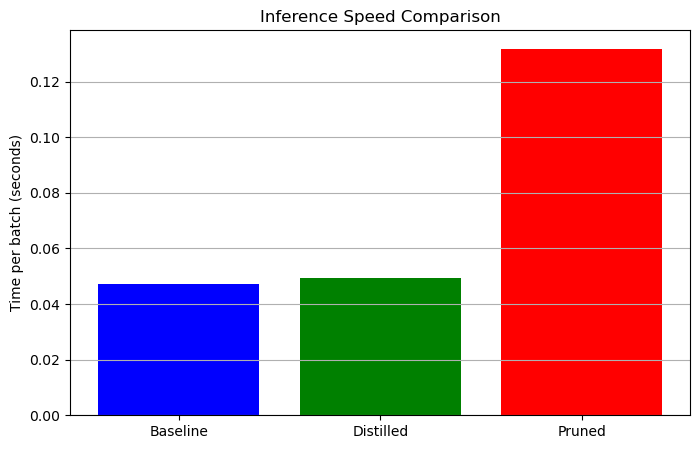

In [21]:
# Compare inference speed
def measure_inference_speed(model, input_ids, n_runs=100):
    model.eval()
    with torch.no_grad():
        # Warmup
        for _ in range(10):
            _ = model(input_ids)
        
        # Measure
        start_time = time.time()
        for _ in range(n_runs):
            _ = model(input_ids)
        end_time = time.time()
    
    return (end_time - start_time) / n_runs

# Prepare input for speed test
test_input = next(iter(val_loader))['input_ids'].to(device)

# Measure speeds
baseline_speed = measure_inference_speed(baseline_model, test_input)
student_speed = measure_inference_speed(student, test_input)
pruned_speed = measure_inference_speed(student_pruned, test_input)

print("\nInference Speed Comparison:")
print(f"Baseline model: {baseline_speed*1000:.2f} ms per batch")
print(f"Distilled model: {student_speed*1000:.2f} ms per batch")
print(f"Pruned model: {pruned_speed*1000:.2f} ms per batch")

# Plot speed comparison
plt.figure(figsize=(8, 5))
plt.bar(['Baseline', 'Distilled', 'Pruned'], 
        [baseline_speed, student_speed, pruned_speed],
        color=['blue', 'green', 'red'])
plt.title('Inference Speed Comparison')
plt.ylabel('Time per batch (seconds)')
plt.grid(True, axis='y')
plt.show()

In [22]:
def calculate_metrics(model, data_loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    perplexities = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            logits, _ = model(input_ids)
            loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1))
            
            # Calculate accuracy
            predictions = torch.argmax(logits[:, :-1], dim=-1)
            correct = (predictions == labels[:, 1:]).sum().item()
            total_correct += correct
            total_tokens += labels[:, 1:].numel()
            
            # Calculate perplexity
            total_loss += loss.item()
            perplexity = torch.exp(loss)
            perplexities.append(perplexity.item())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_tokens
    avg_perplexity = sum(perplexities) / len(perplexities)
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'perplexity': avg_perplexity
    }

Evaluation Results:

Baseline Model:
Loss: 6.6253
Accuracy: 4.22%
Perplexity: 796.51

Distilled Model:
Loss: 8.6693
Accuracy: 3.80%
Perplexity: 5984.02

Pruned Model:
Loss: 8.9243
Accuracy: 3.74%
Perplexity: 7712.02


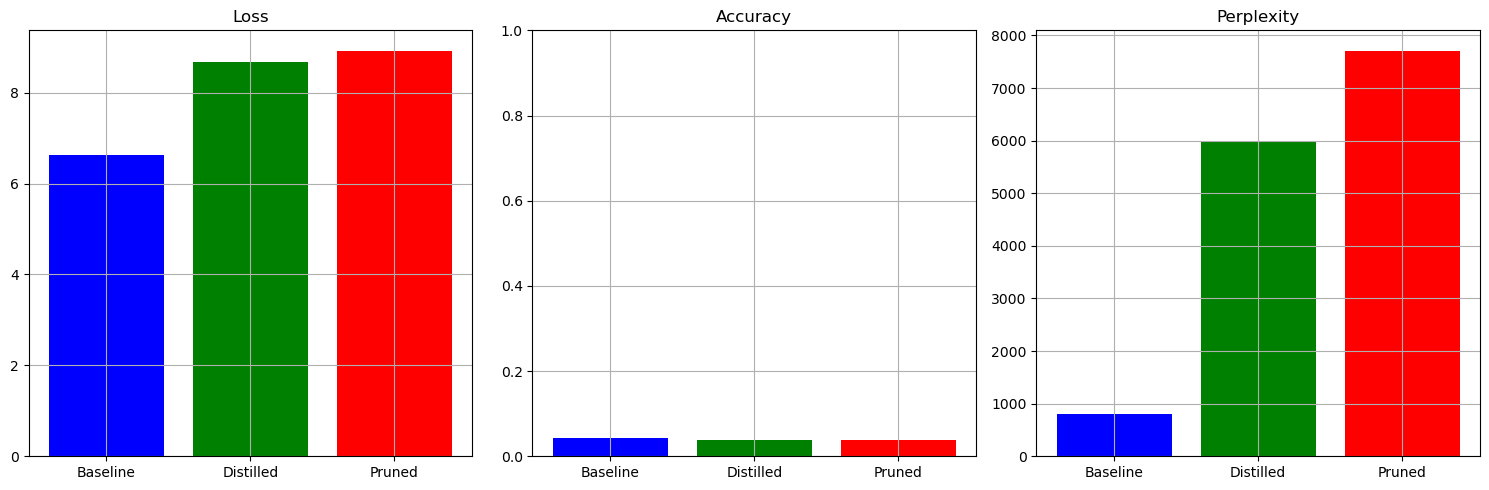

In [23]:
# Calculate metrics for all models
baseline_metrics = calculate_metrics(baseline_model, val_loader)
student_metrics = calculate_metrics(student, val_loader)
pruned_metrics = calculate_metrics(student_pruned, val_loader)

# Print results
print("Evaluation Results:")
print("\nBaseline Model:")
print(f"Loss: {baseline_metrics['loss']:.4f}")
print(f"Accuracy: {baseline_metrics['accuracy']*100:.2f}%")
print(f"Perplexity: {baseline_metrics['perplexity']:.2f}")

print("\nDistilled Model:")
print(f"Loss: {student_metrics['loss']:.4f}")
print(f"Accuracy: {student_metrics['accuracy']*100:.2f}%")
print(f"Perplexity: {student_metrics['perplexity']:.2f}")

print("\nPruned Model:")
print(f"Loss: {pruned_metrics['loss']:.4f}")
print(f"Accuracy: {pruned_metrics['accuracy']*100:.2f}%")
print(f"Perplexity: {pruned_metrics['perplexity']:.2f}")

# Visualize metrics comparison
metrics = ['Loss', 'Accuracy', 'Perplexity']
models = ['Baseline', 'Distilled', 'Pruned']
values = np.array([
    [baseline_metrics['loss'], baseline_metrics['accuracy'], baseline_metrics['perplexity']],
    [student_metrics['loss'], student_metrics['accuracy'], student_metrics['perplexity']],
    [pruned_metrics['loss'], pruned_metrics['accuracy'], pruned_metrics['perplexity']]
])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (metric, ax) in enumerate(zip(metrics, axes)):
    ax.bar(models, values[:, i], color=['blue', 'green', 'red'])
    ax.set_title(metric)
    ax.grid(True)
    if metric == 'Accuracy':
        ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

## 6. Comprehensive Evaluation

Let's evaluate the models using various metrics to get a complete picture of their performance.

In [24]:
# Visualize attention patterns
def plot_attention_patterns(model, text, tokenizer):
    model.eval()
    tokens = tokenizer.encode(text, return_tensors='pt').to(device)
    with torch.no_grad():
        _, attn_weights = model(tokens)
    
    # Average attention weights across heads
    avg_attn = torch.mean(attn_weights[-1], dim=1).squeeze()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_attn.cpu(), cmap='viridis')
    plt.title('Last Layer Attention Pattern')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.show()

In [25]:
sample_text = "The development of artificial intelligence has revolutionized modern technology."
print("\nAttention patterns for baseline model:")
plot_attention_patterns(baseline_model, sample_text, tokenizer)
print("\nAttention patterns for distilled model:")
plot_attention_patterns(student, sample_text, tokenizer)


Attention patterns for baseline model:


TypeError: 'NoneType' object is not subscriptable

In [26]:
# Text generation function
@torch.no_grad()
def generate_text(model, tokenizer, prompt, max_length=100, temperature=0.7):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    
    for _ in range(max_length):
        outputs = model(input_ids)
        next_token_logits = outputs[0][0, -1, :] / temperature
        filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=50, top_p=0.9)
        next_token = torch.multinomial(torch.softmax(filtered_logits, dim=-1), num_samples=1)
        input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
        
        if next_token.item() == tokenizer.eos_token_id:
            break
    
    return tokenizer.decode(input_ids[0], skip_special_tokens=True)

def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    top_k = min(top_k, logits.size(-1))
    if top_k > 0:
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value
    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0
        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits

# Generate sample texts
print("Sample generations from baseline model:")
prompt = "In the early days of artificial intelligence"
for temp in [0.7, 1.0]:
    text = generate_text(baseline_model, tokenizer, prompt, temperature=temp)
    print(f"\nTemperature {temp}:")
    print(text)

print("\nSample generations from distilled model:")
for temp in [0.7, 1.0]:
    text = generate_text(student, tokenizer, prompt, temperature=temp)
    print(f"\nTemperature {temp}:")
    print(text)

Sample generations from baseline model:

Temperature 0.7:
In the early days of artificial intelligence . 
 = = 
 = = = 
 The first first second @-@ 000 of the same name , the other ) . The new first two time of the British on the season , and the main time , which he had been the country , the first early , the first time . The next . The number of the season , but a new group of the second of the first time , and the end of the game was also not a few , the first two , and the

Temperature 0.7:
In the early days of artificial intelligence . 
 = = 
 = = = 
 The first first second @-@ 000 of the same name , the other ) . The new first two time of the British on the season , and the main time , which he had been the country , the first early , the first time . The next . The number of the season , but a new group of the second of the first time , and the end of the game was also not a few , the first two , and the

Temperature 1.0:
In the early days of artificial intelligence of the New 

## 5. Advanced Analysis

Let's perform a more detailed analysis of the models' behavior and performance.

ValueError: x and y must have same first dimension, but have shapes (8,) and (7,)

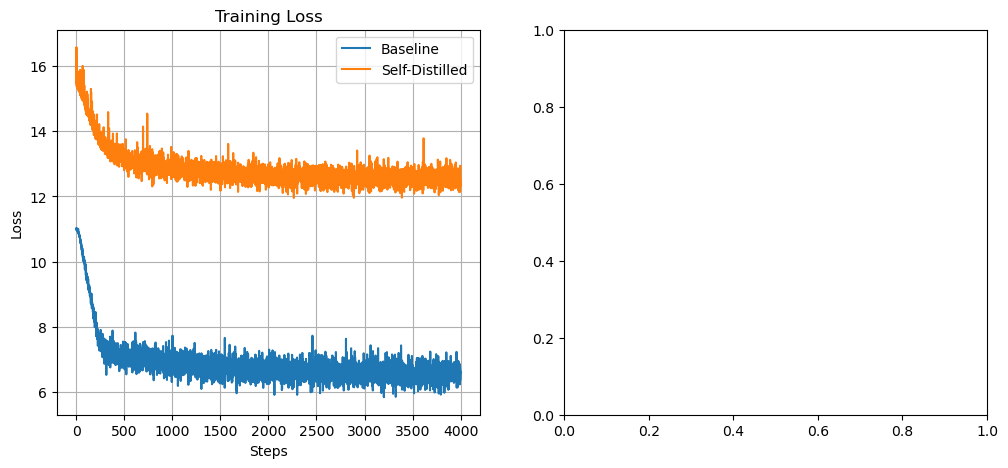

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(baseline_history['train_loss'], label='Baseline')
plt.plot(distill_history['train_loss'], label='Self-Distilled')
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot validation perplexity
plt.subplot(1, 2, 2)
eval_steps = range(train_cfg.eval_every, train_cfg.train_steps + 1, train_cfg.eval_every)
plt.plot(eval_steps, baseline_history['val_ppl'], label='Baseline', marker='o')
plt.plot(eval_steps, distill_history['val_ppl'], label='Self-Distilled', marker='o')
plt.title('Validation Perplexity')
plt.xlabel('Steps')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Analysis of Results

From the plots, we can typically observe the following:

*   **Training Loss:** The self-distilled model might have a higher total training loss initially because it's optimizing a composite loss (LM + KD + SD). However, it often converges to a better solution.
*   **Validation Perplexity:** The key benefit of self-distillation should be visible here. The distilled model is expected to achieve a lower perplexity on the validation set, indicating better generalization. The teacher model, being an EMA of the student, provides a more stable and accurate target, guiding the student to learn more robust representations.

## 7. Conclusion

This notebook demonstrated the core functionalities of the Self-Distilling Transformers project. We've seen how to:
- Configure the model, distillation, and training.
- Create a dataset and data loaders.
- Train a student model with a teacher model via self-distillation.
- Evaluate the model's performance.
- Prune the model to a smaller size.

In [ ]:
# Final cleanup
import gc

del student_pruned
del new_trainer

if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()